# Download ADEX data using resource id and adex credentials

In [1]:
import ipywidgets as widgets
from IPython.display import display
import subprocess

# enter resource id to download
RESOURCE_ID = "1d5d1a32-4afa-44fd-96e0-c99bd72119a8"

# Create widgets for client credentials
clientid_widget = widgets.Password(description='Client ID:', placeholder='ClientID')
clientsecret_widget = widgets.Password(description='Client Secret:', placeholder='ClientSecret')

# Output widget to display messages
output = widgets.Output()

# Function to execute the command
def execute_command(b):
    with output:
        output.clear_output()  # Clear previous outputs
        client_id = clientid_widget.value
        client_secret = clientsecret_widget.value
        command = f"iudx --entity {RESOURCE_ID} --clientid={client_id} --secret={client_secret} --entity-type=resource --role=consumer --download=data --type=parquet --auth_url=https://ts.adex.org.in/auth/v1 --cat_url=https://ts.adex.org.in/adex/cat/v1 --rs_url=https://rs.ts.adex.org.in/ngsi-ld/v1"
        
        # Print the command for debugging
        print(f"Executing: {command}")
        
        # Execute the command
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

        # Check if the command was successful and print the appropriate message
        if process.returncode == 0:
            print("Downloaded the dataset")
        else:
            print("Failed to download the dataset")

# Create a button to trigger the command execution
execute_button = widgets.Button(description='Execute Command')
execute_button.on_click(execute_command)

# Display the widgets, button, and output area
display(clientid_widget)
display(clientsecret_widget)
display(execute_button)
display(output)

'''
enter Client ID, CLient secret
copy resource ID from the catalogue
Output: Enter output file name without space. File will be downloaded in the working directory
'''


Password(description='Client ID:', placeholder='ClientID')

Password(description='Client Secret:', placeholder='ClientSecret')

Button(description='Execute Command', style=ButtonStyle())

Output()

'\nenter Client ID, CLient secret\ncopy resource ID from the catalogue\nOutput: Enter output file name without space. File will be downloaded in the working directory\n'

## PRE-MONSOON WATER QUALITY ANALYSIS
1. Download the PreMonsoon_water_quality dataset using the resource id "1d5d1a32-4afa-44fd-96e0-c99bd72119a8"
2. The csv file is downloaded as zip file
3. Unzip the file and use it for further analysis

### Preprocess the downloaded dataset

In [2]:
# Import the necessary libraries
import pandas as pd
import os

# Read the Parquet file using the correct function
WQ = pd.read_parquet("./data.parquet")


In [3]:
#Display the columns
WQ.columns

Index(['waterLevel', 'year', 'rsc', 'id', 'so4', 'electricalConductivity',
       'fluorine', 'sar', 'no3', 'cl', 'potassium', 'districtName', 'th', 'ca',
       'mg', 'pH', 'hco3', 'villageName', 'season', 'category',
       'subdistrictName', 'na', 'tds', 'co3', 'location.coordinates',
       'location.type'],
      dtype='object')

In [4]:
# Display unique values in the 'season' column
season_values = WQ['season'].unique()
print(season_values)

['premonsoon 2018' 'pre monsoon 2019']


In [5]:
'''
Filter the dataframe where 'season' = 'premonsoon 2018'
save the filtered dataframe as a csv file
'''
#Filter the DataFrame for 'premonsoon 2018' 
filtered_df = WQ[WQ['season'] == 'premonsoon 2018']

# Display the first few rows of the filtered DataFrame for verification
# print(filtered_df.head())

#Save the filtered DataFrame to a new CSV file
filtered_file = "PreMonsoon_WQ_filtered.csv"
filtered_df.to_csv(filtered_file, index=False)

print("Filtered data saved to 'PreMonsoon_WQ_filtered.csv'")


Filtered data saved to 'PreMonsoon_WQ_filtered.csv'


### Create point file in geojson format using the location information in the column 'location.coordinates' of the csv file

In [28]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import re

# Read the CSV file
df = pd.read_csv(os.path.join((os.getcwd()), filtered_file)) # Reading filtered_file - name specified in above code block

def clean_coordinates(coord):
    # Remove spaces immediately after '[' and before ']'
    coord = re.sub(r'\[\s*', '[', coord)
    coord = re.sub(r'\s*\]', ']', coord)
    return coord

def parse_coordinates(coord):
    coord = coord.replace("[", "").replace("]", "")
    splt = coord.split(",")
    return float(splt[0]), float(splt[1])

# First clean the coordinates
df['location.coordinates'] = df['location.coordinates'].apply(clean_coordinates)

# Then apply the parsing function to create new columns for longitude and latitude
df[['longitude', 'latitude']] = df['location.coordinates'].apply(parse_coordinates).apply(pd.Series)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"  # The coordinates are in WGS84
)

# Save the GeoDataFrame as a GeoJSON file
geojson_point = "WQ_premonsoon.geojson"
gdf.to_file(geojson_point, driver='GeoJSON')

print(f"GeoJSON saved as '{geojson_point}'")


GeoJSON saved as 'WQ_premonsoon.geojson'


### Plot the point data and view the attributes of each point, when you click on it

In [29]:
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(os.path.join((os.getcwd()), geojson_point)) #Reading geojson_point - name specified in above code block

# Create a basemap using Folium
m = folium.Map(location=[gdf['latitude'].mean(), gdf['longitude'].mean()], zoom_start=10)

# Create a MarkerCluster layer for the points
marker_cluster = MarkerCluster().add_to(m)

# Add each point to the MarkerCluster layer with a popup containing all attributes
for idx, row in gdf.iterrows():
    popup_fields = [f"<b>{col}:</b> {val}" for col, val in row.items()]
    popup_html = "<br>".join(popup_fields)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=folium.Popup(popup_html, max_width=300)
                  ).add_to(marker_cluster)

# Display the map
m


---

## SPATIAL INTERPOLATION
### Spatial interpolation is a statistical method used to estimate unknown values at specific geographic locations based on known values from surrounding locations. It is commonly used in geographic information systems (GIS) to create continuous surface data from discrete sample points.

[The below code performs spatial interpolation using gdal library] 

In [30]:
'''
Available algorithms and parameters with their defaults:
    Inverse distance to a power (default)
        invdist:power=2.0:smoothing=0.0:radius1=0.0:radius2=0.0:angle=0.0:max_points=0:min_points=0:nodata=0.0
    Inverse distance to a power with nearest neighbor search
        invdistnn:power=2.0:radius=1.0:max_points=12:min_points=0:nodata=0
    Moving average
        average:radius1=0.0:radius2=0.0:angle=0.0:min_points=0:nodata=0.0
    Nearest neighbor
        nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0
    Various data metrics
        <metric name>:radius1=0.0:radius2=0.0:angle=0.0:min_points=0:nodata=0.0
        possible metrics are:
            minimum
            maximum
            range
            count
            average_distance
            average_distance_pts
    Linear
        linear:radius=-1.0:nodata=0.0
'''

'\nAvailable algorithms and parameters with their defaults:\n    Inverse distance to a power (default)\n        invdist:power=2.0:smoothing=0.0:radius1=0.0:radius2=0.0:angle=0.0:max_points=0:min_points=0:nodata=0.0\n    Inverse distance to a power with nearest neighbor search\n        invdistnn:power=2.0:radius=1.0:max_points=12:min_points=0:nodata=0\n    Moving average\n        average:radius1=0.0:radius2=0.0:angle=0.0:min_points=0:nodata=0.0\n    Nearest neighbor\n        nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0\n    Various data metrics\n        <metric name>:radius1=0.0:radius2=0.0:angle=0.0:min_points=0:nodata=0.0\n        possible metrics are:\n            minimum\n            maximum\n            range\n            count\n            average_distance\n            average_distance_pts\n    Linear\n        linear:radius=-1.0:nodata=0.0\n'

In [31]:
'''
The spatial interpolation is performed using 'gdal_grid'. Refer below link for the documentation
https://gdal.org/programs/gdal_grid.html

Run below GDAL command using subprocess

gdal_grid -a nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0 -outsize 30 30 -of GTiff -ot Float64 -zfield pH <input.shp> <output.tif>

Replace <input.shp> with the shapefile name or the path to shapefile
you can also change other parameters

'''

"\nThe spatial interpolation is performed using 'gdal_grid'. Refer below link for the documentation\nhttps://gdal.org/programs/gdal_grid.html\n\nRun below GDAL command using subprocess\n\ngdal_grid -a nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0 -outsize 30 30 -of GTiff -ot Float64 -zfield pH <input.shp> <output.tif>\n\nReplace <input.shp> with the shapefile name or the path to shapefile\nyou can also change other parameters\n\n"

In [32]:
import subprocess
input_point_file = os.path.join((os.getcwd()), geojson_point)
tiff_file = "interpolated_pH.tif"
output_tiff_file = os.path.join((os.getcwd()), tiff_file) #write the path to output file
interpolated_img = [
    'gdal_grid',
    '-a', 'nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0',
    '-outsize', '30', '30',#specify output raster cell size
    '-of', 'GTiff',
    '-ot', 'Float64',
    '-zfield', 'pH', #you can interpolate other parameters also
    input_point_file,
    output_tiff_file
]

# Run the interpolated_img command
subprocess.run(interpolated_img)

Grid data type is "Float64"
Grid size = (30 30).
Corner coordinates = (77.386385 19.794457)-(80.958537 15.832539).
Grid cell size = (0.115231 0.127804).
Source point count = 375.
Algorithm name: "nearest".
Options are "radius1=0.000000:radius2=0.000000:angle=0.000000:nodata=0.000000"

0...10...20...30

CompletedProcess(args=['gdal_grid', '-a', 'nearest:radius1=0.0:radius2=0.0:angle=0.0:nodata=0.0', '-outsize', '30', '30', '-of', 'GTiff', '-ot', 'Float64', '-zfield', 'pH', '/home/jovyan/WQ_premonsoon.geojson', '/home/jovyan/interpolated_pH.tif'], returncode=0)

### Compare pH range of point data and the interpolated data

In [33]:
import geopandas as gpd
import rasterio

# read the geojson file
gdf = gpd.read_file(os.path.join((os.getcwd()), geojson_point))

# Find the maximum and minimum values of pH in the the point file
max_value_pt = gdf['pH'].max()
min_value_pt = gdf['pH'].min()


# read the interpolated tiff file
raster_path = os.path.join((os.getcwd()), tiff_file)

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    data = src.read(1)  # Read the first band
    
    # Calculate the minimum and maximum values
    min_value_ras = data.min()
    max_value_ras = data.max()

# Print the results
print(f"For point data: \nMin value: {min_value_pt} and Max value: {max_value_pt}")
print(f"For interpolated data: \nMin value: {min_value_ras} and Max value: {max_value_ras}")


For point data: 
Min value: 6.84 and Max value: 9.31
For interpolated data: 
Min value: 7.0 and Max value: 9.31


## VISUALIZATION
### To visualize the interpolated image and plot histogram

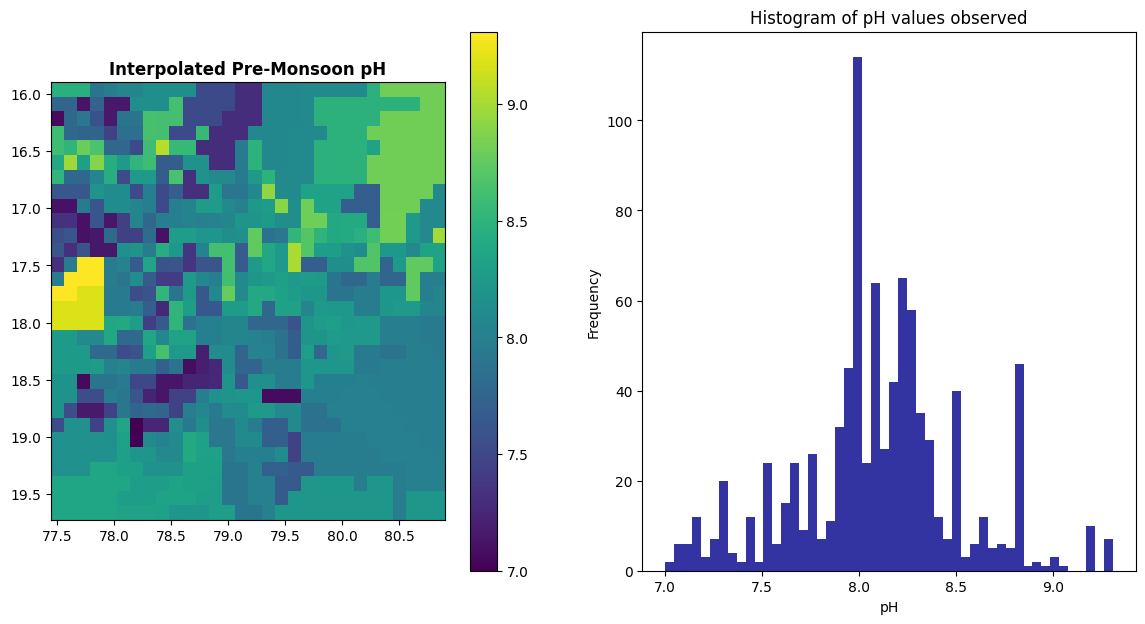

In [34]:
# Import necessary libraries
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from rasterio.plot import show

# Open the interpolated file
src = rasterio.open(os.path.join((os.getcwd()), tiff_file))

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the raster image
img = show(src, ax=axrgb, title="Interpolated Pre-Monsoon pH")

# Generate colorbar for the raster image
fig.colorbar(img.get_images()[0], ax=axrgb)

# Extract the raster data
raster_data = src.read(1)

# Generate histogram with blue color
axhist.hist(raster_data.flatten(), bins=50, histtype='stepfilled',
            lw=0.0, stacked=False, alpha=0.8, color='#00008B')
axhist.set_title("Histogram of pH values observed")
axhist.set_xlabel("pH")
axhist.set_ylabel("Frequency")

# Display the plots of image and histogram
plt.show()

# Save the plot
fig.savefig("Histogram_viz.png")



## VISUALIZATION
### To visualize the interpolated image and point file and also save the interactive map as a html file

In [35]:
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.raster_layers import ImageOverlay
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(os.path.join((os.getcwd()), geojson_point))

# Convert the GeoDataFrame to EPSG 7755
gdf = gdf.to_crs("EPSG:7755")

# Drop NaN values and extract coordinates
coordinates = gdf[['longitude', 'latitude']].dropna()

# Open the raster file
raster_path = os.path.join((os.getcwd()), tiff_file)
src = rasterio.open(raster_path)

# Get raster bounds
bounds = src.bounds
img_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

# Read the raster data
raster_data = src.read(1)

# Get minimum and maximum pH values
min_ph = np.nanmin(raster_data)
max_ph = np.nanmax(raster_data)

# Save the raster data as an image with a colormap
temp_image_path = 'temp_raster_image.png'
plt.imsave(temp_image_path, raster_data, cmap='viridis')  # Change 'viridis' to any other colormap as desired

# Create a Folium map
m = folium.Map(location=[coordinates['latitude'].mean(), coordinates['longitude'].mean()], zoom_start=10)

# Create a MarkerCluster layer for the points
marker_cluster = MarkerCluster(name="Original Data Points").add_to(m)

# Add each point to the MarkerCluster layer with a popup containing all attributes
for idx, row in gdf.iterrows():
    popup_fields = [f"<b>{col}:</b> {val}" for col, val in row.items()]
    popup_html = "<br>".join(popup_fields)
    folium.Marker(location=[row['latitude'], row['longitude']],
                  popup=folium.Popup(popup_html, max_width=300),
                  icon=folium.Icon(color='blue')
                  ).add_to(marker_cluster)

# Add the image overlay to the map
interpolated_overlay = ImageOverlay(
    name='Interpolated pH Layer',
    image=temp_image_path,
    bounds=img_bounds,
    opacity=0.6
)

interpolated_overlay.add_to(m)

# Add custom legend for the raster data
legend_html = f'''
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 150px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;
     padding: 10px;
     ">
     <h4>Legend</h4>
     <h4>pH Range</h4>
     <div style="background:linear-gradient(to right, #440154, #21908C, #FDE725); width: 100%; height: 20px; margin-top: 5px;"></div>
     <div style="float: left;">{min_ph}</div>
     <div style="float: right;">{max_ph}</div>
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control to toggle layers on and off
folium.LayerControl().add_to(m)

# Save the map to an HTML file
output_html = "interpolated_pH_map.html"
m.save(output_html)
print(f"Map saved as {output_html}")

# Display the map
m

Map saved as interpolated_pH_map.html


## INFERENCES

**Premonsoon Water Quality Assessment: Analyzing pH Variability in Telangana State**

Water quality analysis is crucial for understanding the health and safety of water resources, especially in regions prone to seasonal variations like monsoons. The premonsoon water quality analysis provides essential insights into the baseline conditions before the onset of heavy rains. In Telangana state, where water resources play a vital role in agriculture, industry, and daily life, monitoring water quality becomes even more critical. Analyzing pH levels in water is an integral part of water quality assessment. pH is a measure of the acidity or alkalinity of a solution, with values ranging from 0 to 14. A pH of 7 is considered neutral, while values below 7 indicate acidity and above 7 indicate alkalinity. Different aquatic organisms thrive under specific pH conditions, making pH an essential parameter to monitor in water bodies. Using premonsoon water quality data from the year 2018, further analysis was conducted by interpolating the data, plotting histograms, and visualizing using basemaps. The focus was on analyzing the pH parameter of the water.

Data available as csv file was plotted as point file and then interpolated. Comparing the pH range of point values and interpolated raster data reveals interesting insights. For point data, the minimum pH value was 6.84, while the maximum was 9.31. In contrast, for interpolated data, the minimum pH value slightly increased to 7.0, while the maximum remained the same at 9.31. This suggests that while there is a small difference in the minimum pH value, it is negligible. Moreover, the region of interest shows a prevalence of more basic water, as indicated by the pH values. A histogram of the interpolated pH values was also plotted, revealing notable patterns. The maximum observations were in the range of 7.8 to 8.4, with a peak frequency observed at 7.9. This suggests that the majority of pH values fall within a relatively narrow range, with a few outliers at higher pH values. Further analysis of these outliers could provide insights into specific areas of concern or sources of contamination.

Visualizing the interpolated raster image over a basemap highlighted spatial patterns in pH distribution. It was observed that areas with higher pH values were concentrated in the western part of the region of interest. This spatial information can help in identifying hotspots or areas requiring targeted interventions for water quality management. Inferences drawn from the analysis indicate that high pH values, such as 9.31, are observed in specific areas like Bidar, Zaheerabad, Narayankhed, and Kohir. Additionally, pH values greater than 9 are observed in and around Vijayawada. These findings can guide policymakers, researchers, and stakeholders in implementing measures to address water quality concerns and ensure the sustainable management of water resources in Telangana state.
